In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from PIL import Image

device = torch.device('cuda')

In [2]:
class CIFAR100CustomDataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        # Load the CIFAR-100 dataset
        self.data = datasets.CIFAR100(root=root, train=train, download=True)
        self.transform = transform

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Get an image and its label
        img, label = self.data[idx]

        # Apply the transformations if provided
        if self.transform:
            img = self.transform(img)

        return img, label

In [3]:
transform = transforms.Compose([
    # transforms.Resize((64, 64)),  # Resize to 64x64 for VQ-VAE input
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

In [4]:
train_dataset = CIFAR100CustomDataset(root='./data', train=True, transform=transform)
test_dataset = CIFAR100CustomDataset(root='./data', train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

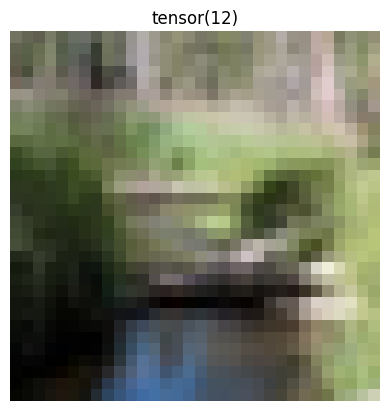

In [7]:
def show_single_image(image, label):
    plt.imshow(image.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize and permute to HWC
    plt.title(label)
    plt.axis('off')
    plt.show()

show_single_image(images[10], labels[10])

In [8]:
# class VQVAE(nn.Module):
#     def __init__(self, num_embeddings, embedding_dim):
#         super(VQVAE, self).__init__()
        
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # [64, 64, 32, 32]
#             nn.ReLU(),
#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # [64, 128, 16, 16]
#             nn.ReLU(),
#             nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # [64, 256, 8, 8]
#             nn.ReLU(),
#             nn.Conv2d(256, embedding_dim, kernel_size=1)  # Final Layer: [batch_size, embedding_dim, 8, 8]
#         )
        
#         self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        
#          # Decoder
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(embedding_dim, 256, kernel_size=4, stride=2, padding=1),  # [64, 256, 16, 16]
#             nn.ReLU(),
#             nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # [64, 128, 32, 32]
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [64, 64, 64, 64]
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 3, kernel_size=1)  # Output Layer: [batch_size, 3, 64, 64]
#         )

#     def forward(self, x):
#         # Encoder output
#         z_e = self.encoder(x)  # Shape: [batch_size, embedding_dim, 8, 8]
#         print(f'z_e shape: {z_e.shape}')

#         # Flatten the encoder output
#         z_e_flattened = z_e.view(z_e.size(0), z_e.size(1), -1)  # Shape: [batch_size, embedding_dim, 64]
#         print(f'z_e_flattened shape: {z_e_flattened.shape}')

#         # Quantization
#         distances = (z_e_flattened.unsqueeze(2) - self.embeddings.weight.unsqueeze(0)).pow(2).sum(1)
#         encoding_indices = torch.argmin(distances, dim=2)

#         z_q = self.embeddings(encoding_indices)  # Shape: [batch_size, height * width, embedding_dim]
#         z_q = z_q.permute(0, 2, 1).view(z_e.size(0), z_e.size(1), z_e.size(2)*z_e.size(2), z_e.size(3))  # Shape: [batch_size, embedding_dim, 8, 8]
#         print(f'z_q shape after reshaping: {z_q.shape}')

#         # Decoder
#         reconstructed = self.decoder(z_q)  # Shape: [batch_size, 3, 64, 64]
#         print(f'reconstructed shape: {reconstructed.shape}')

#         return z_e, z_q, reconstructed

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Upsample from 8x8 to 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # Upsample from 16x16 to 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),   # Upsample from 32x32 to 64x64
            nn.Sigmoid()  # Output in range [0, 1] for images
        )

    def forward(self, z_q):
        # Reshape z_q to match the input size expected by the decoder
        # z_q will be of shape [batch_size, 64, 64] before reshaping
        z_q = z_q.view(z_q.size(0), 64, 8, 8)  # Reshape back to 8x8 before feeding to the decoder
        
        # Pass through decoder layers
        reconstructed = self.decoder_layers(z_q)
        return reconstructed


class VQVAE(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=64):
        super(VQVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # Output: [32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: [64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1)   # Output: [64, 8, 8]
        )

        # Embeddings
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        
        # Decoder using the Decoder class
        self.decoder = Decoder()

    def forward(self, x):
        # Encoder output
        z_e = self.encoder(x)  # Shape: [batch_size, 64, 8, 8]
        print(f'z_e shape: {z_e.shape}')
        
        # Flatten the encoder output
        z_e_flattened = z_e.view(z_e.size(0), z_e.size(1), -1)  # Shape: [batch_size, 64, 64]
        print(f'z_e_flattened shape: {z_e_flattened.shape}')

        # Reshape embeddings to compare with z_e_flattened for distances calculation
        # z_e_flattened: [batch_size, embedding_dim, height*width] -> [batch_size, embedding_dim, flattened size]
        # embeddings.weight: [num_embeddings, embedding_dim] -> [1, num_embeddings, embedding_dim]
        z_e_flattened = z_e_flattened.permute(0, 2, 1)  # Shape: [batch_size, 64, embedding_dim]
        
        distances = (z_e_flattened.unsqueeze(2) - self.embeddings.weight.unsqueeze(0)).pow(2).sum(3)  # Shape: [batch_size, 64, num_embeddings]
        encoding_indices = torch.argmin(distances, dim=2)  # Find closest embedding
        print(f'distances shape: {distances.shape}')
        print(f'encoding_indices shape: {encoding_indices.shape}')

        # Retrieve the quantized latent vectors (z_q) from the embeddings
        z_q = self.embeddings(encoding_indices)
        print(f'z_q shape: {z_q.shape}')  # Shape: [batch_size, height * width, embedding_dim]

        # Reshape to match encoder dimensions for decoder
        z_q = z_q.permute(0, 2, 1)  # Shape: [batch_size, 64, 512]
        z_q = z_q.view(z_e.size(0), z_e.size(1), z_e.size(2), z_e.size(3))  # Reshaped for decoder input
        
        print(f'z_q shape after reshaping: {z_q.shape}')  # Output: [batch_size, 64, 8, 8]

        # Decoder
        reconstructed = self.decoder(z_q)  # Should match input image size
        print(f'reconstructed shape: {reconstructed.shape}')  # Output: [batch_size, 3, 64, 64]

        return z_e, z_q, reconstructed  # Return encoded, quantized, and reconstructed representations

In [9]:
model = VQVAE(num_embeddings=512, embedding_dim=64)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [10]:
model.to(device)

VQVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (embeddings): Embedding(512, 64)
  (decoder): Decoder(
    (decoder_layers): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): Sigmoid()
    )
  )
)

In [11]:
# List to store loss values for plotting
loss_values = []
val_loss_values = []

# Variable initialization to store the best validation loss
best_val_loss = float('inf')

for epoch in range(50):
    model.train()  # Model in training mode
    total_loss = 0
    
    # TQDM progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/50 (VQ-VAE)")
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        z_e, z_q, reconstructed = model(images)  # Get encoded, quantized, and reconstructed outputs
        
        # Calculate loss
        # 1. Reconstruction loss (MSE loss between input images and reconstructed images)
        reconstruction_loss = F.mse_loss(reconstructed, images) 
        
        # 2. Commitment loss (VQ loss)
        commitment_loss = F.mse_loss(z_e.detach(), z_q) + F.mse_loss(z_e, z_q.detach())

        # Total loss
        loss = reconstruction_loss + commitment_loss
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Update TQDM progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())
    
    # Calculate the average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    
    # Print the average loss for the current epoch
    print(f"Epoch [{epoch+1}/50], Avg Loss: {avg_loss:.4f}")
    
    # --- Validation loop ---
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    
    with torch.no_grad():  # Disable gradient calculations during validation
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            
            # Forward pass
            val_z_e, val_z_q, val_reconstructed = model(val_images)
            
            # Calculate validation loss
            val_reconstruction_loss = F.mse_loss(val_reconstructed, val_images) 
            val_commitment_loss = F.mse_loss(val_z_e.detach(), val_z_q) + F.mse_loss(val_z_e, val_z_q.detach())
            val_loss = val_reconstruction_loss + val_commitment_loss
            
            total_val_loss += val_loss.item()
    
    # Calculate the average validation loss for this epoch
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_values.append(avg_val_loss)

    # Print the average validation loss for the current epoch
    print(f"Epoch [{epoch+1}/50], Avg Validation Loss: {avg_val_loss:.4f}")
    
    # --- Model selection based on validation loss ---
    if avg_val_loss < best_val_loss and (epoch+1) % 5 == 0:
        best_val_loss = avg_val_loss
        print(f"Validation loss improved. Saving the best model at epoch {epoch+1}.")
        torch.save(model.state_dict(), f'model_vqvae_cifar100/best_model_epoch_{epoch+1}.pth')


Epoch 1/50 (VQ-VAE):   0%|          | 0/782 [00:00<?, ?it/s]

z_e shape: torch.Size([64, 64, 4, 4])
z_e_flattened shape: torch.Size([64, 64, 16])
distances shape: torch.Size([64, 16, 512])
encoding_indices shape: torch.Size([64, 16])


Epoch 1/50 (VQ-VAE):   0%|          | 0/782 [00:01<?, ?it/s]

z_q shape: torch.Size([64, 16, 64])
z_q shape after reshaping: torch.Size([64, 64, 4, 4])


RuntimeError: shape '[64, 64, 8, 8]' is invalid for input of size 65536